In [1]:
!pip install --quiet neural_structured_learning

     |████████████████████████████████| 122kB 6.8MB/s 


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import keras_preprocessing
import neural_structured_learning as nsl
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
import zipfile

from tensorflow.keras import models
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# Beans Dataset

In [3]:
#@title An instance of tfds.dataset
dataset = 'beans'#@param


In [23]:
#@title Params 
# TODO: Put into config class

# Model Params/Configs. 
BATCH_SIZE = 47
N_EPOCHS = 5

# Adversarial Reg Config Params
ADV_MULTIPLIER = 0.2
ADV_STEP_SIZE = 0.2
ADV_GRADE_NORM = 'infinity'

In [5]:
# Load images, define train, test and dict keys
dataset = tfds.load(dataset, shuffle_files=True)
train, test = dataset['train'], dataset['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete1CIIMA/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete1CIIMA/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete1CIIMA/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [6]:
# Get random img samples
raw_images = train.take(10)
raw_images = [item['image'] for item in raw_images.as_numpy_iterator()]

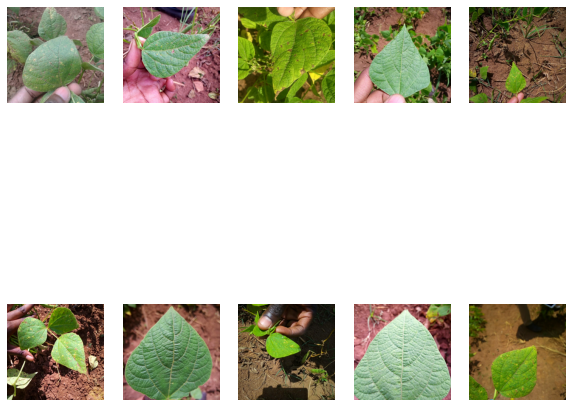

In [6]:
# Plot batch
fig = plt.gcf()
fig.set_size_inches(10, 10)
for i, img in enumerate(raw_images):
  sp = plt.subplot(2, 5, i+1)
  sp.axis('Off')
  plt.imshow(img)
plt.show()

In [7]:
#@title Preprocessing 
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 500.0
  return features

def examples_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def examples_to_dict(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

train_dataset = train.map(normalize).shuffle(5000).batch(BATCH_SIZE).map(
    examples_to_tuples)
test_dataset = test.map(normalize).batch(BATCH_SIZE).map(
    examples_to_tuples)

In [52]:
#@title Define model
def conv_nn_model(img_input_shape: tuple) -> tf.keras.Model():
  """Simple Conv2D Neural Network.
    Args:
      img_input_shape: An (mxnxo) tuple defining the input image shape. 
    Returns:
      model: An instance of tf.keras.Model.
  """
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # Note to adjust output layer for number of classes
    tf.keras.layers.Dense(3, activation='softmax')])
  return model

In [53]:
input_shape = (500,500,3)
baseline_model = conv_nn_model(input_shape)
baseline_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 115200)          

In [54]:
baseline_model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])
baseline_history = baseline_model.fit(train_dataset, epochs=N_EPOCHS)

Epoch 1/5
22/22 [==============================] - 7s 338ms/step - loss: 1.3320 - acc: 0.3849
Epoch 2/5
22/22 [==============================] - 7s 333ms/step - loss: 0.8927 - acc: 0.5822
Epoch 3/5
22/22 [==============================] - 7s 332ms/step - loss: 0.6974 - acc: 0.7099
Epoch 4/5
22/22 [==============================] - 7s 334ms/step - loss: 0.5766 - acc: 0.7534
Epoch 5/5
22/22 [==============================] - 7s 335ms/step - loss: 0.4609 - acc: 0.8191


In [55]:
results = baseline_model.evaluate(test_dataset)
print(f'Baseline Accuracy: {results[1]}')

3/3 [==============================] - 0s 71ms/step - loss: 0.5665 - acc: 0.7891
Baseline Accuracy: 0.7890625


In [15]:
#@title Get random img sample
test_images = train.take(12)
test_images = [item['image'] for item in test_images.as_numpy_iterator()]

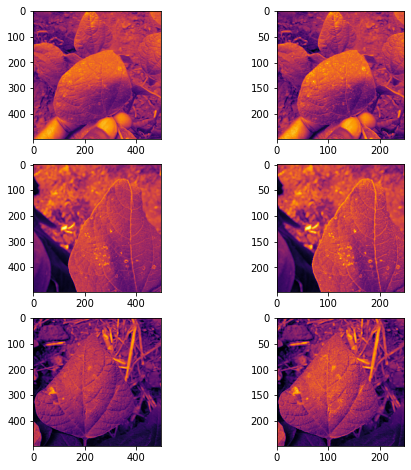

In [26]:
#@title Intermediate img representation by conv layer
f, axarr = plt.subplots(3,2, figsize=(8, 8))
IDX_IMAGE_1=2
IDX_IMAGE_2=5
IDX_IMAGE_3=10
CONVOLUTION_NUMBER = 10

layer_outputs = [layer.output for layer in baseline_model.layers]
activation_model = tf.keras.models.Model(
    inputs = baseline_model.input, 
    outputs = layer_outputs)

for x in range(0, 2):
  f1 = activation_model.predict(test_images[IDX_IMAGE_1].reshape(1, 500, 500, 3))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[IDX_IMAGE_2].reshape(1, 500, 500, 3))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[IDX_IMAGE_3].reshape(1, 500, 500, 3))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

In [56]:
#@title Adversarial Regularization Config
adv_reg_config = nsl.configs.make_adv_reg_config(
    multiplier=ADV_MULTIPLIER,
    adv_step_size=ADV_STEP_SIZE,
    adv_grad_norm=ADV_GRADE_NORM
)

In [57]:
#@title Define Adversarially Reg. Model
base_adv_model = conv_nn_model(input_shape)
adv_reg_model = nsl.keras.AdversarialRegularization(
    base_adv_model, 
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_reg_config
)

train_set_for_adv_model = train_dataset.map(examples_to_dict)
test_set_for_adv_model = test_dataset.map(examples_to_dict)

In [58]:
adv_reg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
adv_reg_model.fit(train_set_for_adv_model, epochs=N_EPOCHS)

Epoch 1/5


22/22 [==============================] - 14s 636ms/step - loss: 1.5597 - sparse_categorical_crossentropy: 1.2206 - sparse_categorical_accuracy: 0.3752 - scaled_adversarial_loss: 0.3392
Epoch 2/5
22/22 [==============================] - 14s 633ms/step - loss: 1.2656 - sparse_categorical_crossentropy: 1.0404 - sparse_categorical_accuracy: 0.4739 - scaled_adversarial_loss: 0.2252
Epoch 3/5
22/22 [==============================] - 14s 638ms/step - loss: 1.1628 - sparse_categorical_crossentropy: 0.9407 - sparse_categorical_accuracy: 0.5861 - scaled_adversarial_loss: 0.2221
Epoch 4/5
22/22 [==============================] - 14s 630ms/step - loss: 0.9765 - sparse_categorical_crossentropy: 0.7544 - sparse_categorical_accuracy: 0.6905 - scaled_adversarial_loss: 0.2221
Epoch 5/5
22/22 [==============================] - 14s 632ms/step - loss: 0.9212 - sparse_categorical_crossentropy: 0.6994 - sparse_categorical_accuracy: 0.6925 - scaled_adversarial_loss: 0.2218


In [59]:
results = adv_reg_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_reg_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

3/3 [==============================] - 1s 221ms/step - loss: 0.8933 - sparse_categorical_crossentropy: 0.6725 - sparse_categorical_accuracy: 0.7109 - scaled_adversarial_loss: 0.2208

accuracy: 0.7109375


In [60]:
#@title Define ref model to generate adv examples
reference_model = nsl.keras.AdversarialRegularization(
    baseline_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_reg_config)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [61]:
# Dict of models to compare, and target perf. metrics
models_to_eval = {
    'base': baseline_model,
    'adv-regularized': adv_reg_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [ ]:
#@title Evaluate models
labels, y_preds = [], []
for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y = perturbed_batch.pop(LABEL_INPUT_NAME)
  y_preds.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y, y_pred)
    y_preds[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print(f'{name} model accuracy: {metric.result().numpy()}')

In [63]:
#@title Generate adv perturbed batches
perturbed_images = []
for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  perturbed_images.append(perturbed_batch)

In [48]:
pt_img = [item['image'] for item in perturbed_images]

In [49]:
IDX_IMAGE_1=0
IDX_IMAGE_2=1
IDX_IMAGE_3=2
CONVOLUTION_NUMBER = 11

base_mod_layer_out = [layer.output for layer in baseline_model.layers]
base_mod_activ = tf.keras.models.Model(
    inputs = baseline_model.input, 
    outputs = base_mod_layer_out)

f1 = base_mod_activ.predict(pt_img[IDX_IMAGE_1].numpy())[x]
f2 = base_mod_activ.predict(pt_img[IDX_IMAGE_2].numpy())[x]
f3 = base_mod_activ.predict(pt_img[IDX_IMAGE_3].numpy())[x]

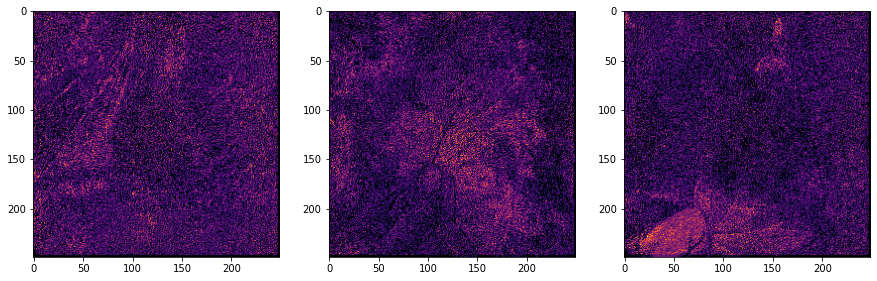

In [50]:
#@title View conv layer img repres.
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')